In [1]:
!pwd

/Users/ariellubonja/prog/drugs-embedding


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch as torch
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
basic_drugs = ['ibuprofen', 'paracetamol', 'acetaminophen', 'irbesartan', 'valsartan', 'nifedipine', 'lidocaine', 'nifedipine+lidocaine']

In [8]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

mat = np.zeros([8, 768])
i=0
for drug in basic_drugs:
    inputs = tokenizer.encode(drug, return_tensors="pt")
    with torch.no_grad():
        last_hidden_states = model(inputs)[0] # Models outputs are now tuples
        last_hidden_states = last_hidden_states.mean(1)
        mat[i,:] = last_hidden_states
        i+=1
        
dist_out = 1-pairwise_distances(mat, metric="cosine")
dist_out

NameError: name 'tokenizer' is not defined

In [9]:
# Read the list of molecules
import pandas as pd
molecules = pd.read_excel("data/gain-synonyms-list.xlsx")

In [11]:
molecules_list = list(molecules['Gain'].str.lower())
# selected_molecules = [m.split(" ")[-1] for m in molecules_list[0:7000] if (("+" not in m) and 

selected_molecules = [m for m in molecules_list[0:7000] if (("+" not in m) and 
                      (m.endswith("olol") or 
                      m.endswith('cillin') or 
                      m.endswith('sartan') or 
                      m.endswith('mycin') or 
                      m.endswith('vir') or 
                      m.endswith('parin') or
                      m.endswith('mab') or 
                      m.endswith('lamide') or
                      m.endswith('caine') or
                      m.endswith('bital') or
                      m.endswith('afil') or
                      m.endswith('asone') or
                      m.endswith('profen') or 
                      m.endswith('statin') or
                      m.endswith('tinib')))]

In [12]:
selected_molecules = list(set(selected_molecules))
len(selected_molecules)

337

In [13]:
selected_molecules[:30]

['l01en02 pemigatinib',
 'saquinavir',
 'pemigatinib',
 'dolutegravir',
 'sofosbuvir',
 'eprosartan',
 'j01ca04 amoxicillin',
 'l01ed03 alectinib',
 'j05ar10 lopinavir and ritonavir',
 'palivizumab',
 'roxithromycin',
 'azilsartan',
 'n01ba04 chloroprocaine',
 'c07aa05 propranolol',
 'mezlocillin',
 'dexamethasone',
 'ampicillin',
 'n01bb01 bupivacaine',
 'pravastatin',
 'osimertinib',
 'l01ex01 sunitinib',
 'benzocaine',
 'j01cf02 cloxacillin',
 'tobramycin',
 'g04be10 avanafil',
 'n03aa02 phenobarbital',
 'b01ab01 heparin',
 'mepolizumab',
 'j01cf05 flucloxacillin',
 'l01eh03 tucatinib']

In [11]:
#embeddings and cosines
mat = np.zeros([len(selected_molecules), 768])
i=0
print("Computing embeddings...")
for drug in selected_molecules:
    inputs = tokenizer.encode(drug, return_tensors="pt")
    with torch.no_grad():
        last_hidden_states = model(inputs)[0] # Models outputs are now tuples
        last_hidden_states = last_hidden_states.mean(1)
        mat[i,:] = last_hidden_states
        i+=1
print("Computing cosines...")
dist_out = 1-pairwise_distances(mat, metric="cosine")
dist_out

Computing embeddings...
Computing cosines...


array([[1.        , 0.81735075, 0.8082188 , ..., 0.81508124, 0.92771123,
        0.90187813],
       [0.81735075, 1.        , 0.85609839, ..., 0.93466495, 0.84124491,
        0.8652657 ],
       [0.8082188 , 0.85609839, 1.        , ..., 0.85734916, 0.84610848,
        0.87898063],
       ...,
       [0.81508124, 0.93466495, 0.85734916, ..., 1.        , 0.84040178,
        0.86764335],
       [0.92771123, 0.84124491, 0.84610848, ..., 0.84040178, 1.        ,
        0.96697361],
       [0.90187813, 0.8652657 , 0.87898063, ..., 0.86764335, 0.96697361,
        1.        ]])

In [156]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
Z = linkage(mat, metric = 'cosine', method = 'single')

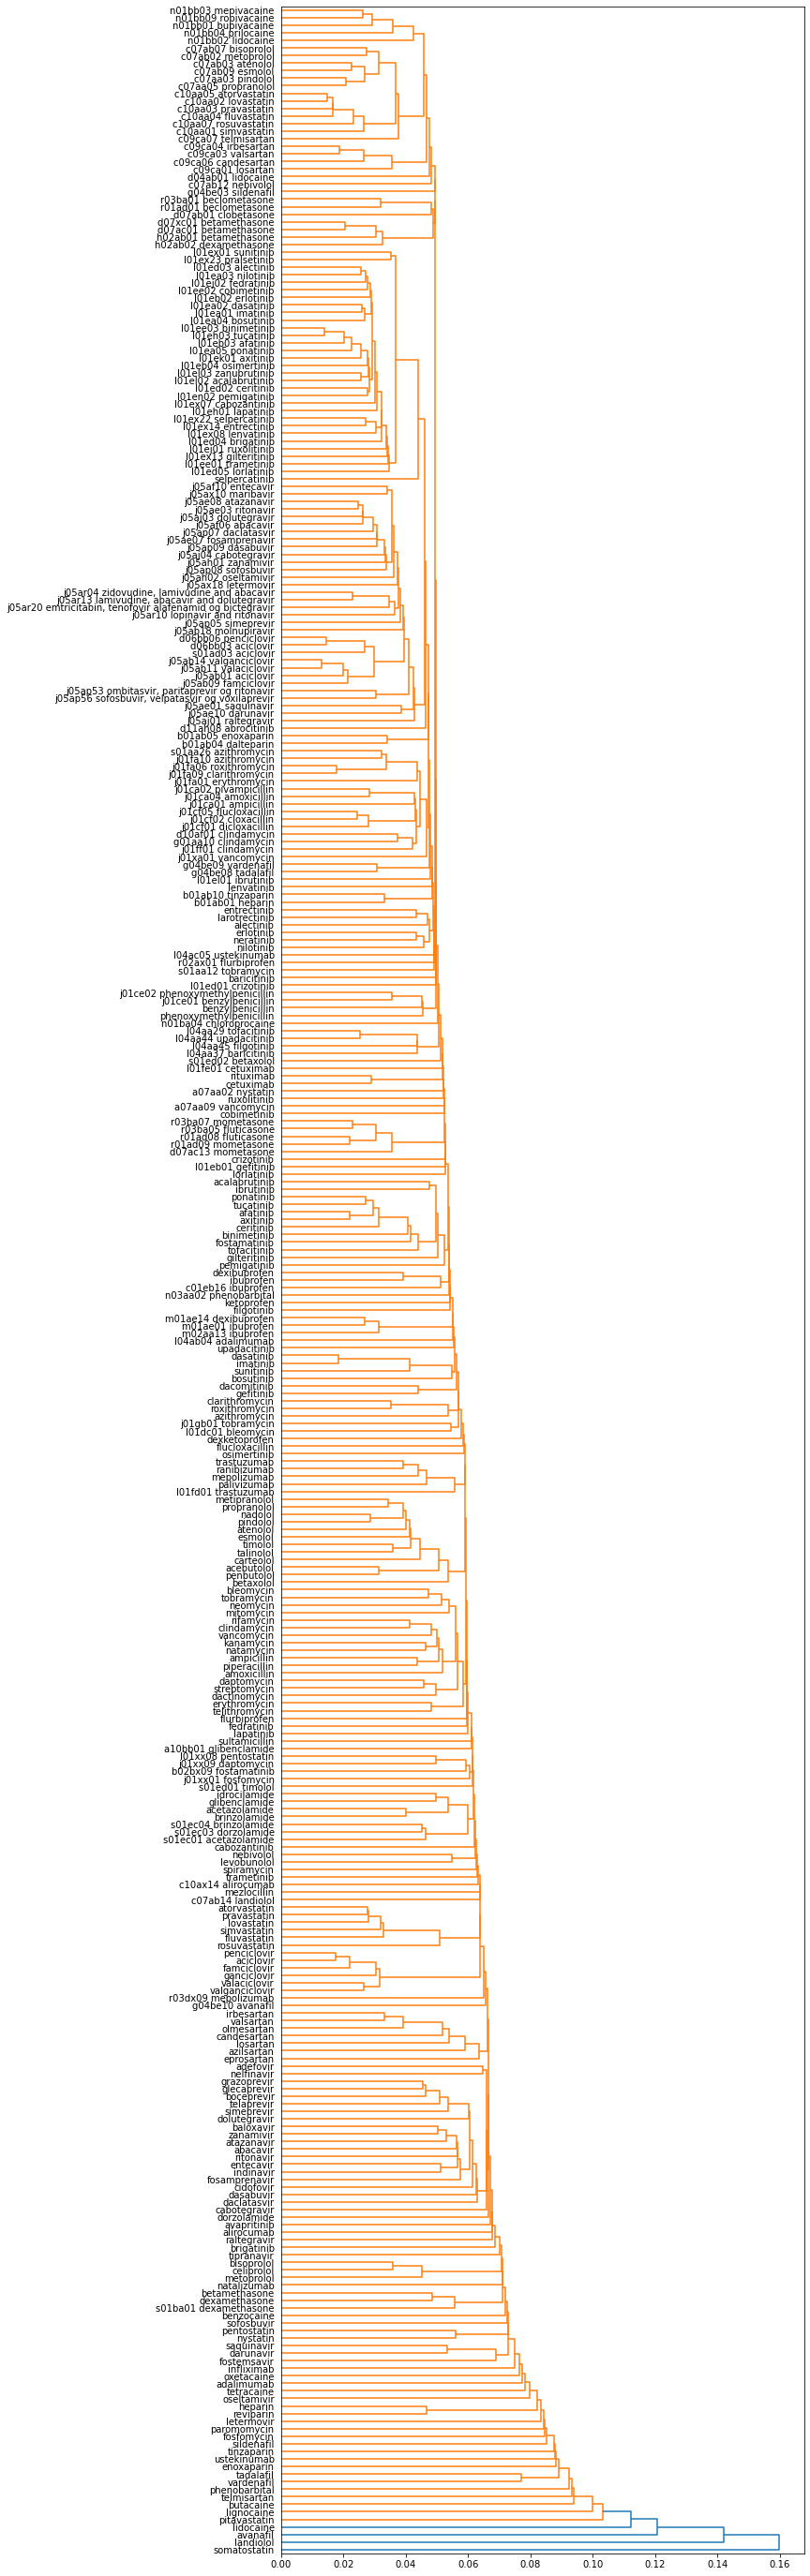

In [158]:
fig = plt.figure(figsize=(10, 50))
# dn = dendrogram(Z)
dendrogram(
            Z,
            orientation='right',
            labels=selected_molecules,
#             distance_sort='descending',
#             show_leaf_counts=False
          )
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.show()

In [149]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(distance_threshold=0.06,
                                               n_clusters = None,
                                               affinity='cosine', 
                                               linkage='single',
                                               compute_distances = True)
labels = hierarchical_cluster.fit_predict(mat)


In [150]:
labels

array([29,  0, 67,  6,  5, 65, 62, 58,  1,  2,  0, 17,  0,  0,  5,  4,  5,
       20,  4, 44, 30,  4, 46,  4, 14,  6, 47, 70, 10, 63, 64, 71,  1, 16,
        1,  0, 45, 20,  6,  0,  3, 57,  0, 55,  6,  5,  2,  0,  0, 30,  6,
       49, 41, 31,  2, 36,  0, 29,  8,  5, 60,  0, 51, 37, 13,  1, 29,  6,
        4, 46, 69,  3,  8, 59,  2,  0, 35,  3, 28,  4, 40,  0, 56,  0,  1,
        6,  5,  0,  7,  3,  0,  4,  6, 17,  0, 38, 54, 14, 43, 39,  9,  4,
        0, 48, 13,  6,  0,  0,  3,  0,  0,  6,  0, 52, 61,  0,  6, 53, 68,
        0,  0, 23, 13, 26,  0,  0,  0, 22,  4,  0, 45, 14,  6, 66,  3,  0,
        9,  0, 27,  0,  7,  6,  7,  0, 18,  6,  0,  3,  0, 10,  4, 32,  0,
        3, 14,  6, 42,  9,  6, 25, 14,  0,  0,  9,  6, 13, 50,  6,  0,  3,
       12, 35, 29, 16, 20,  6, 33, 15, 13,  3,  4,  0, 13, 19,  0, 22,  4,
        2,  2, 21, 24, 72, 14, 11,  6, 34], dtype=int64)

In [151]:
for i in set(labels):
    print([selected_molecules[j] for j in range(len(selected_molecules)) if labels[j]==i])
    print("\n")

['erlotinib', 'sunitinib', 'upadacitinib', 'cobimetinib', 'ceritinib', 'trametinib', 'acalabrutinib', 'baricitinib', 'lapatinib', 'imatinib', 'axitinib', 'neratinib', 'alectinib', 'filgotinib', 'larotrectinib', 'binimetinib', 'ruxolitinib', 'nilotinib', 'gilteritinib', 'gefitinib', 'zanubrutinib', 'dasatinib', 'bosutinib', 'fostamatinib', 'ponatinib', 'pralsetinib', 'afatinib', 'rituximab', 'lenvatinib', 'lorlatinib', 'dacomitinib', 'osimertinib', 'tucatinib', 'pemigatinib', 'ibrutinib', 'crizotinib', 'entrectinib', 'abrocitinib', 'fedratinib', 'tofacitinib', 'cetuximab', 'selpercatinib']


['ibuprofen', 'dexibuprofen', 'dexketoprofen', 'flurbiprofen', 'ketoprofen']


['olmesartan', 'valsartan', 'losartan', 'azilsartan', 'candesartan', 'irbesartan']


['dasabuvir', 'zanamivir', 'atazanavir', 'abacavir', 'indinavir', 'ritonavir', 'entecavir', 'baloxavir', 'maribavir', 'fosamprenavir']


['penbutolol', 'metipranolol', 'nadolol', 'esmolol', 'timolol', 'carteolol', 'pindolol', 'acebutolol'

In [144]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 20)
 
mat_small = pca.fit_transform(mat)

Y = linkage(mat_small, metric = 'cosine', method = 'single', optimal_ordering=True)

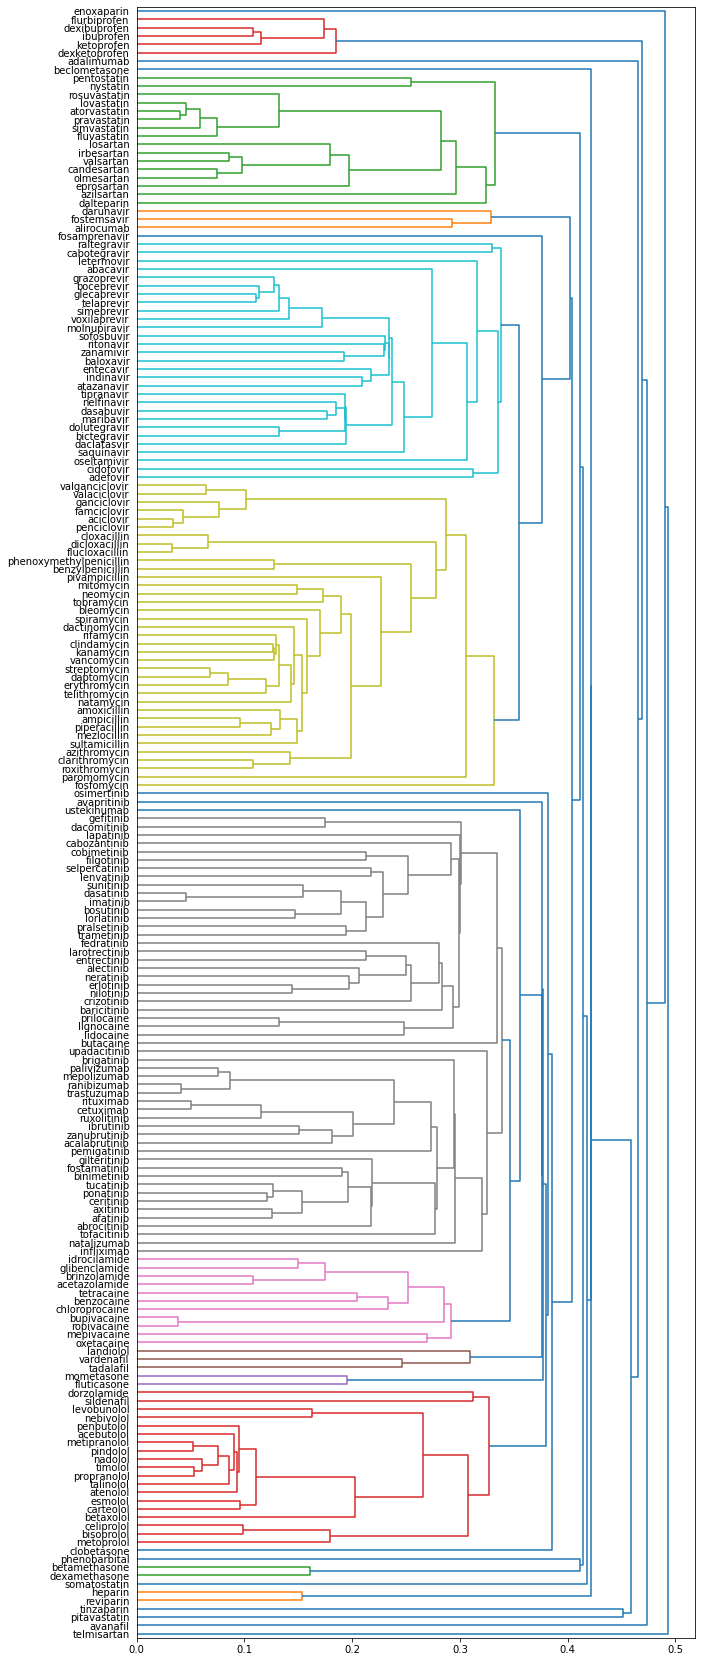

In [145]:
fig = plt.figure(figsize=(10, 30))
# dn = dendrogram(Z)
dendrogram(
            Y,
            orientation='right',
            labels=selected_molecules
#             distance_sort='descending',
#             show_leaf_counts=False
          )
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.show()

In [ ]:
Y

# TODO LLM embeddings

1. Llama
2. Saudi thing (Falcon?)

# TODO Use Drug Class from Drugs.com as ground truth

In [1]:
# https://python.langchain.com/docs/modules/data_connection/text_embedding/integrations/llamacpp

from langchain.embeddings import LlamaCppEmbeddings
import numpy as np

In [2]:
# I got GGML from here https://huggingface.co/Pi3141/alpaca-native-7B-ggml/tree/397e872bf4c83f4c642317a5bf65ce84a105786e
# Need llama-cpp-python=0.1.48 for this to work
llama = LlamaCppEmbeddings(model_path="models/ggml-model-q4_0.bin")

llama.cpp: loading model from models/ggml-model-q4_0.bin
llama.cpp: can't use mmap because tensors are not aligned; convert to new format to avoid this
llama_model_load_internal: format     = 'ggml' (old version with low tokenizer quality and no mmap support)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 2 (mostly Q4_0)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size = 4113748.20 KB
llama_model_load_internal: mem required  = 5809.33 MB (+ 2052.00 MB per state)
...................................................................................................
.
llama_

In [3]:
text = "ibuprofen"
query_result = llama.embed_query(text)
np.array(query_result).shape


llama_print_timings:        load time =   302.45 ms
llama_print_timings:      sample time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings: prompt eval time =   299.86 ms /     5 tokens (   59.97 ms per token)
llama_print_timings:        eval time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings:       total time =   304.78 ms


(4096,)

In [6]:
# doc_result = llama.embed_documents([text])
# np.array(doc_result).shape

# llama.embed_documents and llama.embed_query are the same
# np.all(np.array(query_result) == np.array(doc_result))

In [4]:
from langchain.vectorstores.faiss import FAISS # pip install faiss-cpu

### TODO use newer versions of LlamaCPP + new model version - this is pretty slow

In [ ]:
chunks = selected_molecules # ["ibuprofen", "acetaminofen"]

db0 = FAISS.from_texts(chunks, llama)

In [15]:
# TODO load from disk now
# db0.save_local("indices/selected_molecules_store.faissdb")